# Import the CIFAR10 Dataset

In [1]:
from torchvision import datasets, transforms

transform = transforms.ToTensor() #This scales the image to [0.0, 1.0]

# 50,000 training images
train_images = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 10,000 test images
test_images = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:43<00:00, 3.93MB/s]


In [ ]:
#Print train and test dataset sizes
print(len(train_images))
print(len(test_images))
print(train_images[0][0].shape)

50000
10000
torch.Size([3, 32, 32])


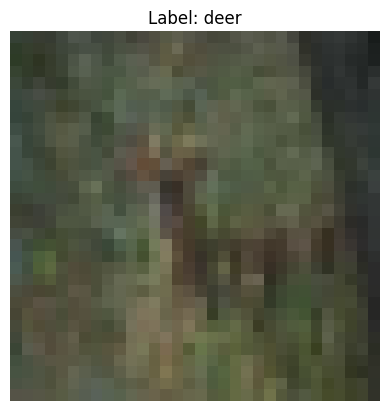

Label: deer


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Get the image and label from the dataset
image, label = train_images[10]

# Convert the tensor image to a format matplotlib can handle
# (it expects [H, W, C] instead of [C, H, W])
image = F.to_pil_image(image)

# Show the image
plt.imshow(image)
plt.title(f"Label: {train_images.classes[label]}")
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Class distribution in training set')

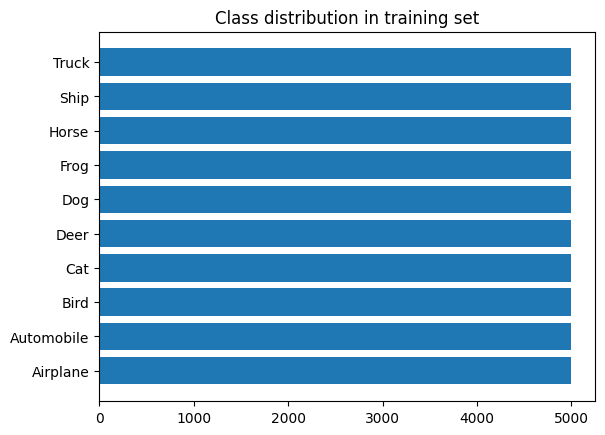

In [ ]:
#Check the distribution of classed in the data to check the balance
import numpy as np

classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
# Extract all labels from the dataset
labels = [label for _, label in train_images]

classes, counts = np.unique(labels, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

#Dataset is perfectly balances and accuracy is a good performance matrix for it

# Data Pre-processing

## Normalizarion

I chose per-channel normalization and I think is better because R, G, and B channels often have different brightness levels, and handling them independently helps the model learn better.

In [2]:
#Get the mean and std of the channels of the images (RGB)
from torch.utils.data import DataLoader

# Step 2: Use a DataLoader to load all training images in one batch
train_loader = DataLoader(train_images, batch_size=len(train_images), shuffle=False)

# Step 3: Get all image data from the loader
train_data_tensor = next(iter(train_loader))[0]  # Shape: [50000, 3, 32, 32]

# Step 4: Compute per-channel mean and std (dim: batch, height, width)
mean = train_data_tensor.mean(dim=[0, 2, 3])
std = train_data_tensor.std(dim=[0, 2, 3])

# Step 5: Print the results
print(f"Per-channel mean: {mean}")
print(f"Per-channel std:  {std}")


Per-channel mean: tensor([0.4914, 0.4822, 0.4465])
Per-channel std:  tensor([0.2470, 0.2435, 0.2616])


In [3]:
#Now we normalize both train and test images

# Define the full transform: ToTensor + Normalize
transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Reload the datasets with the new normalization transform
train_images = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_normalized)
test_images = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_normalized)

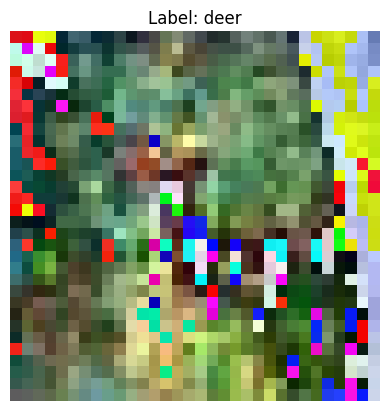

In [ ]:
#I just checked the image to see how does it look afetr normalization. as we see it is quite distorted since values are in the range of -1, +1 for example.
#For seeing the images we should first unnormalize it.

import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Get the image and label from the dataset
image, label = train_images[10]

# Convert the tensor image to a format matplotlib can handle
# (it expects [H, W, C] instead of [C, H, W])
image = F.to_pil_image(image)

# Show the image
plt.imshow(image)
plt.title(f"Label: {train_images.classes[label]}")
plt.axis('off')
plt.show()

 ## Data augmentation to improve generalization

In [4]:
#Do all of the augmentation techniques together + normalization and reload the data

# Compose all augmentations + normalization
transform_all = transforms.Compose([
    transforms.RandomCrop(32, padding=4),                    # Crop with padding
    transforms.RandomHorizontalFlip(),                       # Flip image horizontally
    transforms.ColorJitter(brightness=0.2,                   # Random brightness
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.ToTensor(),                                   # Convert to tensor [0,1]
    transforms.Normalize(mean, std)                          # Normalize with mean/std
])

# New dataset with all augmentations
train_augmented = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_all)

**Note**: We do not do data augmentation on test data, we only do normalization. Cause it is unseen data. These techniques are used fo better generalization on test data.

## One-hot encoding of the labels and splitting data into test, validation, train

Splitting train data into gtrain and validation

In [5]:
from torch.utils.data import random_split, DataLoader

# Splits a dataset into training and validation sets and returns their DataLoaders.
def create_train_val_loaders(dataset, batch_size=64, val_ratio=0.2, seed=42):
    total_size = len(dataset)
    val_size = int(total_size * val_ratio)
    train_size = total_size - val_size

    generator = torch.Generator().manual_seed(seed)
    train_set, val_set = random_split(dataset, [train_size, val_size], generator=generator)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

Defining mini batches to load the data efficiently


In [ ]:
import torch
from torch.utils.data import DataLoader

batch_size = 64  # or 128 depending on your memory

#Based on which train data (which augmentation) we want to work with, we use our train dataset
train_loader, val_loader = create_train_val_loaders(train_images)

#Load the test data without splitting
test_set = test_images
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)


Esanble one-hot encoding

In [ ]:
#show the fist 10 labels of test_images
labels = []
for i in range(10):
    _, label = test_images[i]
    labels.append(label)

print(labels)

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1]


**Attention** The way we loaded the data from pytorch, it already has labels as integers so there is no need for one-hot encoding. So we will use CrossEntropy loss fucntion later and we work with the integers and do not need on-hot encoding further.

# CNN Architecture

***Justification of the coices***

**Convolution Layers**

We implemented a 6-level convolutional structure with 3×3 kernels.

Started with 16 filters and increased the number progressively (e.g., 16 → 32 → 64 → 128 → 256) to extract deeper, more abstract features in later layers.
We will also check the model starting with 32 filters ( 32 → 64 → 128 → 256 → 512)
This follows the standard design pattern used in state-of-the-art CNNs.

**MaxPooling**

We used pool_size=(2, 2) after every couple of convolutional layers.

Downsampling helps reduce spatial dimensions, lowering computational cost.
Helps control overfitting and introduces spatial invariance.

**Activation Functions**

Used ReLU in hidden layers for its simplicity, non-linearity, and efficiency.

Plan to experiment with Leaky ReLU (avoids dying neurons) and ELU (smooth approximation with negative output allowance).

Softmax is used in the output layer for multi-class classification (CIFAR-10 has 10 classes).

**Techniques for Reducing Overfitting**

- Dropout: Randomly zeroes neurons during training to prevent co-adaptation.

Started with 0.2 in early layers and increased to 0.5 in deeper layers where overfitting is more likely.

- Batch Normalization: Applied after each convolutional layer to normalize activations. Improves training stability and speed, and acts as regularization.

- Residual Connections: Implemented skip connections (ResNet-style) to improve gradient flow and allow training of deeper networks.

- Early Stopping: Will be used during training to halt once validation accuracy stops improving, preventing overfitting and saving training time.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ResNet-style Block
class ResidualBlock(nn.Module):
    """Basic ResNet-style residual block with two 3x3 convolutional layers."""
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

**Note**:
A residual block is not a conv layer, but it contains 2 conv layers in my case.
When counting total conv layers, we count the ones inside residual blocks.

**Attention** From now on I will have different CNN structures that have some differences so I can use them later in the training section. Notice that the name of the models are different.

In [7]:
#CNN models that starts with 16 filters

# Full CNN Model
class CustomCNN16(nn.Module):
    def __init__(self, num_classes=10, deep=False):
        super().__init__()
        self.deep = deep  # Store the flag

        # Initial convolution layer (Conv 1)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        # Conv Layers 2 & 3 (Residual Block 1)
        self.block1 = nn.Sequential(
            ResidualBlock(16, 32, downsample=True),
            ResidualBlock(32, 32)
        )

        self.pool1 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        # Conv Layers 4 & 5 (Residual Block 2)
        self.block2 = nn.Sequential(
            ResidualBlock(32, 64, downsample=True),
            ResidualBlock(64, 64),
            nn.Dropout(0.3)
        )

        # Conv Layer 6 (Residual Block 3)
        self.block3 = nn.Sequential(
            ResidualBlock(64, 128, downsample=True),
            nn.Dropout(0.4)
        )

        # Optional block (Residual Block 4)
        if self.deep:
            self.block4 = nn.Sequential(
                ResidualBlock(128, 256, downsample=True),
                nn.Dropout(0.5)
            )
            fc_input_size = 256
        else:
            self.block4 = nn.Identity()  # No-op if deep=False
            fc_input_size = 128

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_input_size * 1 * 1, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
      x = self.conv1(x)
      x = self.block1(x)
      x = self.pool1(x)
      x = self.block2(x)
      x = self.block3(x)
      x = self.block4(x)  # Will be Identity() if deep=False
      x = self.classifier(x)
      return x

Visualize the model

In [8]:
pip install torchsummary

In [9]:
from torchsummary import summary

model = CustomCNN16(num_classes=10, deep=True).to("cuda" if torch.cuda.is_available() else "cpu")
summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 16, 16]             544
       BatchNorm2d-5           [-1, 32, 16, 16]              64
            Conv2d-6           [-1, 32, 16, 16]           4,640
       BatchNorm2d-7           [-1, 32, 16, 16]              64
              ReLU-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           9,248
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
    ResidualBlock-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           9,248
      BatchNorm2d-14           [-1, 32,

In [10]:
#2nd CNN model with deeper levels (first layer has 32 filters)
class CustomCNN32(nn.Module):
    def __init__(self, num_classes=10, deep=False):
        super().__init__()
        self.deep = deep

        # Initial conv layer (Conv 1)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        # Conv Layers 2 & 3 (Residual Block 1)
        self.block1 = nn.Sequential(
            ResidualBlock(32, 64, downsample=True),
            ResidualBlock(64, 64)
        )

        self.pool1 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        # Conv Layers 4 & 5 (Residual Block 2)
        self.block2 = nn.Sequential(
            ResidualBlock(64, 128, downsample=True),
            ResidualBlock(128, 128),
            nn.Dropout(0.3)
        )

        # Conv Layer 6 (Residual Block 3)
        self.block3 = nn.Sequential(
            ResidualBlock(128, 256, downsample=True),
            nn.Dropout(0.4)
        )

        # Optional block (Residual Block 4)
        if self.deep:
            self.block4 = nn.Sequential(
                ResidualBlock(256, 512, downsample=True),
                nn.Dropout(0.5)
            )
            fc_input_size = 512
        else:
            self.block4 = nn.Identity()
            fc_input_size = 256

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_input_size * 1 * 1, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.classifier(x)
        return x

Change activation function to **Leaky Relu**

In [11]:
import torch
import torch.nn as nn

class ResidualBlock_Leaky(nn.Module):
    """ResNet-style residual block using LeakyReLU."""
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(negative_slope=0.01)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)


In [12]:
#3rd CNN model with LEakyRelu and adding with Decay as regularization

class CustomCNN32_LeakyRelu(nn.Module):
    def __init__(self, num_classes=10, deep=False):
        super().__init__()
        self.deep = deep

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01)
        )

        self.block1 = nn.Sequential(
            ResidualBlock_Leaky(32, 64, downsample=True),
            ResidualBlock_Leaky(64, 64)
        )

        self.pool1 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        self.block2 = nn.Sequential(
            ResidualBlock_Leaky(64, 128, downsample=True),
            ResidualBlock_Leaky(128, 128),
            nn.Dropout(0.3)
        )

        self.block3 = nn.Sequential(
            ResidualBlock_Leaky(128, 256, downsample=True),
            nn.Dropout(0.4)
        )

        if self.deep:
            self.block4 = nn.Sequential(
                ResidualBlock_Leaky(256, 512, downsample=True),
                nn.Dropout(0.5)
            )
            fc_input_size = 512
        else:
            self.block4 = nn.Identity()
            fc_input_size = 256

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_input_size * 1 * 1, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.classifier(x)
        return x


Changing the activation function to **ELU**

In [13]:
import torch
import torch.nn as nn

class ResidualBlock_ELU(nn.Module):
    """ResNet-style residual block using ELU activation."""
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.elu = nn.ELU(alpha=0.01)  #Changed from LeakyReLU to ELU

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.elu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.elu(out + identity)

In [14]:
#3rd CNN model with Elu

class CustomCNN32_ELU(nn.Module):
    def __init__(self, num_classes=10, deep=False):
        super().__init__()
        self.deep = deep

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(0.01)
        )

        self.block1 = nn.Sequential(
            ResidualBlock_ELU(32, 64, downsample=True),
            ResidualBlock_ELU(64, 64)
        )

        self.pool1 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        self.block2 = nn.Sequential(
            ResidualBlock_ELU(64, 128, downsample=True),
            ResidualBlock_ELU(128, 128),
            nn.Dropout(0.3)
        )

        self.block3 = nn.Sequential(
            ResidualBlock_ELU(128, 256, downsample=True),
            nn.Dropout(0.4)
        )

        if self.deep:
            self.block4 = nn.Sequential(
                ResidualBlock_ELU(256, 512, downsample=True),
                nn.Dropout(0.5)
            )
            fc_input_size = 512
        else:
            self.block4 = nn.Identity()
            fc_input_size = 256

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_input_size * 1 * 1, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.classifier(x)
        return x


# Exploring models and train

**Note**: I checked two codes on Keggle with good number of upvotes and their test accuracy on CIFAR-10 was 86 and 90. so I am setting a baseline for myself tosee how my model peforms compared to these two.

**Justification of the coices in the training phase**

**Loss Function** – CrossEntropyLoss:


Since this is a multi-class classification task (CIFAR-10 with 10 classes), nn.CrossEntropyLoss is appropriate. It expects raw output logits from the model and integer class labels, which matches our setup.

**Optimizer** – Adam:


Adam is well-suited for training deep CNNs like this one. It adapts the learning rate for each parameter individually, handles noisy gradients well, and usually converges faster without much tuning.

**Learning Rate Scheduler** – ReduceLROnPlateau:


This scheduler lowers the learning rate automatically when validation loss plateaus. It helps refine the learning process during later epochs without manual tuning.

**Weight Initialization** – He Initialization:


He initialization (also known as Kaiming initialization) is designed specifically for ReLU-based networks. It helps maintain signal flow through deep architectures by scaling weights based on the number of input units, reducing the risk of vanishing or exploding gradients.

## First, I run my model without data augmentation to explore training models

In [15]:
#check if we are on GPU: check
import torch
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))

CUDA available: True
Current device: 0
Device name: Tesla T4


### Using th emodel with Relu activation function, and first layer starts with 16 filters

In [ ]:
#Uuing train_images which do not have data augmentation
train_loader, val_loader = create_train_val_loaders(train_images)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# He initialization (Kaiming) for ReLU-based networks
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

# Instantiate model
model = CustomCNN16(num_classes=10, deep=True).to(device) #deep=True so we are using 7 layers
initialize_weights(model)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


**Note**: At first I used 25 epochs and this was my result:

Epoch 25/25 | Train Loss: 1.7444, Acc: 0.7155 | Val Loss: 1.7641, Acc: 0.6951 | Time: 21.0s

Best Validation Accuracy: 0.7045

So clearly it was underfitting so I increased the epochs to 50.

In [ ]:
# Training loop setup
num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0
best_model_state = None

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Scheduler step
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

    # Print progress every 10 epochs or on last epoch
    if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1:02}/{num_epochs} | "
              f"Train Loss: {train_loss:.3f}, Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.3f}, Acc: {val_acc:.3f} | "
              f"Time: {time.time() - start_time:.1f}s")

# Load best model for evaluation
model.load_state_dict(best_model_state)
print("CNN model that first layer starts with 16 filters")
print(f"\nBest Validation Accuracy: {best_val_acc:.3f}")


Epoch 10/50 | Train Loss: 1.830, Acc: 0.629 | Val Loss: 1.825, Acc: 0.634 | Time: 21.6s
Epoch 20/50 | Train Loss: 1.768, Acc: 0.691 | Val Loss: 1.770, Acc: 0.689 | Time: 17.6s
Epoch 30/50 | Train Loss: 1.732, Acc: 0.729 | Val Loss: 1.756, Acc: 0.704 | Time: 18.1s
Epoch 40/50 | Train Loss: 1.682, Acc: 0.778 | Val Loss: 1.718, Acc: 0.743 | Time: 17.5s
Epoch 50/50 | Train Loss: 1.662, Acc: 0.798 | Val Loss: 1.707, Acc: 0.753 | Time: 18.1s

Best Validation Accuracy: 0.758


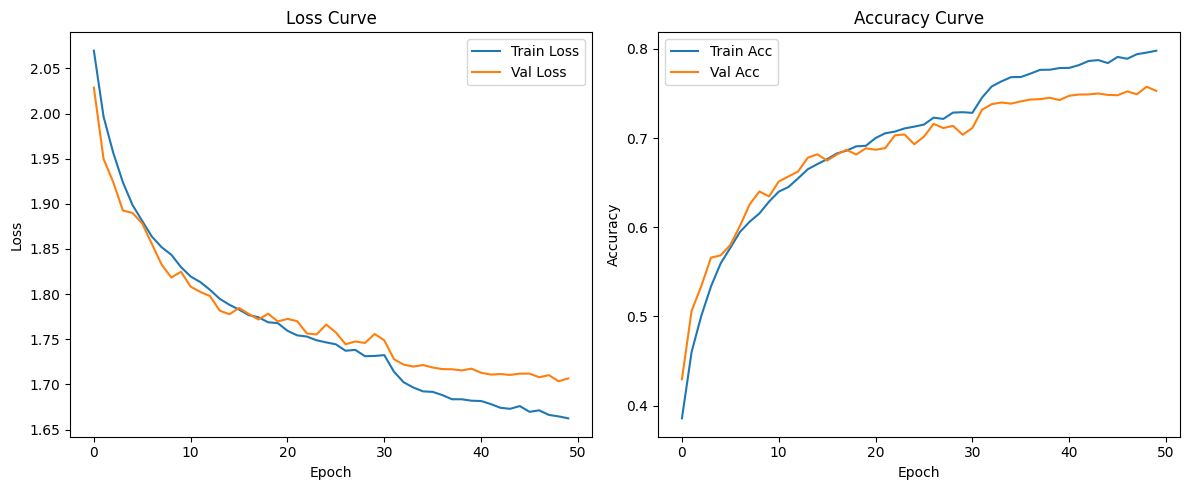

In [ ]:
plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


So it looks that model is not complex enough and we are still underfit, so I increased the depth of the CNN layers and used more filters below.

### Using th model with Relu activation function, and first layer starts with 32 filters

**Note**: With 50 epochs and these were my results:
(I did not keep the code with 50 epocs for a cleaner, shorter code)

Epoch 10/50 | Train Loss: 1.818, Acc: 0.642 | Val Loss: 1.825, Acc: 0.635 | Time: 20.9s

Epoch 20/50 | Train Loss: 1.749, Acc: 0.711 | Val Loss: 1.759, Acc: 0.702 | Time: 20.7s

Epoch 30/50 | Train Loss: 1.713, Acc: 0.747 | Val Loss: 1.752, Acc: 0.708 | Time: 22.5s

Epoch 40/50 | Train Loss: 1.682, Acc: 0.778 | Val Loss: 1.726, Acc: 0.735 | Time: 21.1s

Epoch 50/50 | Train Loss: 1.639, Acc: 0.821 | Val Loss: 1.687, Acc: 0.774 | Time: 21.0s

CNN model that first layer starts with 32 filters
Best Validation Accuracy: 0.774

----

So, these were my observations:
- Not overfitting because validation accuracy keeps rising.
- Not significantly underfitting either — model capacity is sufficient.
- Still a train/val gap, so the model may benefit from a few more epochs or tuning.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# He initialization (Kaiming) for ReLU-based networks
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

# Instantiate model
model = CustomCNN32(num_classes=10, deep=True).to(device) #deep=True so we are using 7 layers
initialize_weights(model)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

In [ ]:
#Using train_images which do not have data augmentation
train_loader, val_loader = create_train_val_loaders(train_images)

In [ ]:
# Increasing epoch from 50 to 100 and added early stopping

# Training settings
num_epochs = 100
early_stopping_patience = 10

# Tracking variables
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0
best_model_state = None
epochs_no_improve = 0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Scheduler step
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0  # reset early stop counter
    else:
        epochs_no_improve += 1

    # Print every 10 epochs or final
    if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1:02}/{num_epochs} | "
              f"Train Loss: {train_loss:.3f}, Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.3f}, Acc: {val_acc:.3f} | "
              f"Time: {time.time() - start_time:.1f}s")

    # Early stopping
    if epochs_no_improve >= early_stopping_patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(best_model_state)
print("CNN model that first layer starts with 32 filters")
print(f"Best Validation Accuracy: {best_val_acc:.3f}")


Epoch 10/100 | Train Loss: 1.821, Acc: 0.638 | Val Loss: 1.819, Acc: 0.640 | Time: 20.2s
Epoch 20/100 | Train Loss: 1.754, Acc: 0.706 | Val Loss: 1.757, Acc: 0.703 | Time: 20.5s
Epoch 30/100 | Train Loss: 1.712, Acc: 0.748 | Val Loss: 1.734, Acc: 0.727 | Time: 20.9s
Epoch 40/100 | Train Loss: 1.686, Acc: 0.774 | Val Loss: 1.722, Acc: 0.739 | Time: 20.2s
Epoch 50/100 | Train Loss: 1.637, Acc: 0.823 | Val Loss: 1.686, Acc: 0.775 | Time: 20.6s
Epoch 60/100 | Train Loss: 1.606, Acc: 0.855 | Val Loss: 1.675, Acc: 0.785 | Time: 20.9s
Epoch 70/100 | Train Loss: 1.591, Acc: 0.870 | Val Loss: 1.665, Acc: 0.795 | Time: 20.8s
Epoch 80/100 | Train Loss: 1.579, Acc: 0.881 | Val Loss: 1.666, Acc: 0.794 | Time: 21.7s
Epoch 90/100 | Train Loss: 1.569, Acc: 0.892 | Val Loss: 1.660, Acc: 0.801 | Time: 20.5s
Epoch 100/100 | Train Loss: 1.561, Acc: 0.899 | Val Loss: 1.657, Acc: 0.804 | Time: 21.1s
CNN model that first layer starts with 32 filters
Best Validation Accuracy: 0.804


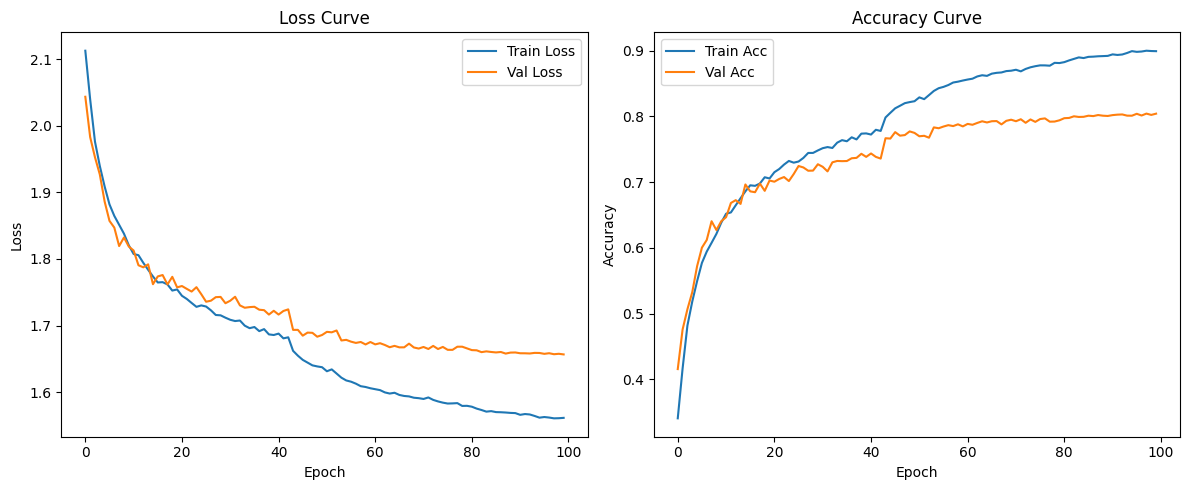

In [ ]:
#Save the best model
torch.save(model.state_dict(), 'best_model_32_7layers_Relu.pth')

#Visualize the performance
plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

Ok, based on the chart we are seeing that there is still room for improvement and we start to see sign of overfitting since the generalization capacity has likely hit a ceiling.

So, there will be our next steps:
- Data Augmentation
- Check LeakyRelu
- Add weigh decays (penalty to the loss that discourages large weights)

## Now that our model is complex enough and started to overfit, we will train the model on train_augmented to look how it perform better on generalization.

I also turned off the 7 layer to decrease the chance of overfitting.

In [16]:
import torch
#Using train_augmented: more diverse input to generalize better
train_loader, val_loader = create_train_val_loaders(train_augmented)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# He initialization (Kaiming) for ReLU-based networks
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

# Instantiate model
model = CustomCNN32(num_classes=10, deep=False).to(device) #deep=False so we are not using 7 layers
initialize_weights(model)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
#To fix the shape mismatch
#Fix classifier input shape based on actual output
model.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        out = model.conv1(images)
        out = model.block1(out)
        out = model.pool1(out)
        out = model.block2(out)
        out = model.block3(out)
        out = model.block4(out)
        flat_dim = out.view(out.size(0), -1).size(1)
        break

# Replace classifier dynamically with correct input size
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(flat_dim, 10),  # 10 classes
    nn.Softmax(dim=1)
)
model.to(device)

CustomCNN32(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [19]:
# Training settings
num_epochs = 100
early_stopping_patience = 10

# Tracking variables
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0
best_model_state = None
epochs_no_improve = 0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Scheduler step
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0  # reset early stop counter
    else:
        epochs_no_improve += 1

    # Print every 10 epochs or final
    if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1:02}/{num_epochs} | "
              f"Train Loss: {train_loss:.3f}, Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.3f}, Acc: {val_acc:.3f} | "
              f"Time: {time.time() - start_time:.1f}s")

    # Early stopping
    if epochs_no_improve >= early_stopping_patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(best_model_state)
print("CNN model with augmentated data and 6 layers")
print(f"Best Validation Accuracy: {best_val_acc:.3f}")


Epoch 10/100 | Train Loss: 1.769, Acc: 0.692 | Val Loss: 1.759, Acc: 0.701 | Time: 51.2s
Epoch 20/100 | Train Loss: 1.702, Acc: 0.759 | Val Loss: 1.696, Acc: 0.765 | Time: 50.7s
Epoch 30/100 | Train Loss: 1.669, Acc: 0.792 | Val Loss: 1.673, Acc: 0.788 | Time: 49.6s
Epoch 40/100 | Train Loss: 1.634, Acc: 0.826 | Val Loss: 1.640, Acc: 0.820 | Time: 50.1s
Epoch 50/100 | Train Loss: 1.617, Acc: 0.844 | Val Loss: 1.635, Acc: 0.824 | Time: 50.5s
Epoch 60/100 | Train Loss: 1.600, Acc: 0.861 | Val Loss: 1.615, Acc: 0.845 | Time: 50.0s
Epoch 70/100 | Train Loss: 1.590, Acc: 0.872 | Val Loss: 1.611, Acc: 0.850 | Time: 49.7s
Epoch 80/100 | Train Loss: 1.587, Acc: 0.874 | Val Loss: 1.610, Acc: 0.852 | Time: 50.7s
Epoch 90/100 | Train Loss: 1.578, Acc: 0.884 | Val Loss: 1.607, Acc: 0.852 | Time: 51.6s

Early stopping triggered at epoch 96
CNN model with augmentated data and 6 layers
Best Validation Accuracy: 0.858


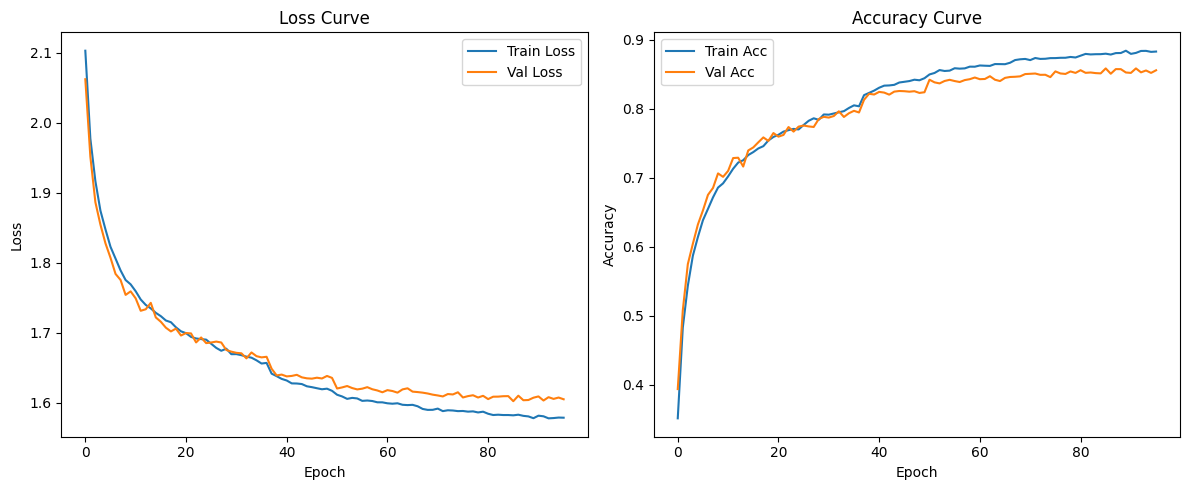

In [20]:
#Save the best model
torch.save(model.state_dict(), 'best_model_6Layers_augmented.pth')

#Visualize the performance
plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

**Interpreting and comparing the results with and without augmentation**

The augmented model achieved a higher best validation accuracy (0.849 vs. 0.804).


Training with augmentation took longer per epoch, but the improvement in validation accuracy (+4.5%) and the fact it generalizes better justifies the added cost.

Early stopping was triggered in the augmented run (at epoch 83), meaning it converged sooner without overfitting.


## Exploring other activation functions. on augemnted data
*Result* Non of them improved the model so we will continue with relu later

In [ ]:
import torch
#Using train_augmented: more diverse input to generalize better
train_loader, val_loader = create_train_val_loaders(train_augmented)

### Now we will change the activation function to LeakyRelu.It will solve the issue of dying neurons and will help slightly with overfitting as well.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# He initialization (Kaiming) for ReLU-based networks
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, a=0.01, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

# Instantiate model
model = CustomCNN32_LeakyRelu(num_classes=10, deep=True).to(device) #deep=True so we are using 7 layers
initialize_weights(model)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Training settings
num_epochs = 80 #The last model had an early stop as 80, also to have a shorter running time
#(The last time I ran the code with augmented data and Relu it stopped at 81 epoch. )
early_stopping_patience = 10

# Tracking variables
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0
best_model_state = None
epochs_no_improve = 0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Scheduler step
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0  # reset early stop counter
    else:
        epochs_no_improve += 1

    # Print every 10 epochs or final
    if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1:02}/{num_epochs} | "
              f"Train Loss: {train_loss:.3f}, Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.3f}, Acc: {val_acc:.3f} | "
              f"Time: {time.time() - start_time:.1f}s")

    # Early stopping
    if epochs_no_improve >= early_stopping_patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(best_model_state)
print("CNN model with augmentated data and Leaky Relu + Regularizarion")
print(f"Best Validation Accuracy: {best_val_acc:.3f}")


Epoch 10/80 | Train Loss: 1.883, Acc: 0.576 | Val Loss: 1.843, Acc: 0.617 | Time: 58.4s
Epoch 20/80 | Train Loss: 1.803, Acc: 0.657 | Val Loss: 1.771, Acc: 0.689 | Time: 56.9s
Epoch 30/80 | Train Loss: 1.740, Acc: 0.721 | Val Loss: 1.722, Acc: 0.739 | Time: 57.4s
Epoch 40/80 | Train Loss: 1.708, Acc: 0.752 | Val Loss: 1.698, Acc: 0.762 | Time: 57.9s
Epoch 50/80 | Train Loss: 1.697, Acc: 0.763 | Val Loss: 1.690, Acc: 0.771 | Time: 57.5s
Epoch 60/80 | Train Loss: 1.665, Acc: 0.796 | Val Loss: 1.665, Acc: 0.796 | Time: 57.6s
Epoch 70/80 | Train Loss: 1.660, Acc: 0.802 | Val Loss: 1.650, Acc: 0.811 | Time: 57.7s


**Note**: Leaky Relu is performing worse on both train and validation datasets, compared to Relu, so we did not continue with it.

These can be the reason why Relu is performing better in our CNN model:

- LeakyReLU Allows Small Negative Activations. This might preserve noise in your feature maps, especially in early layers.
- ReLU’s hard zeroing out of negatives can act as implicit regularization, making the model focus only on strong activations.

### Exploring ELU activation function. It is smooth and will help with overfitting.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Xavier initialization better maintains signal variance for symmetric activations like ELU.
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

# Instantiate model
model = CustomCNN32_ELU(num_classes=10, deep=True).to(device) #deep=True so we are using 7 layers
initialize_weights(model)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

In [ ]:
# Training settings
num_epochs = 80 #The last model had an early stop as 80, also to have a shorter running time
#(The last time I ran the code with augmented data and Relu it stopped at 81 epoch. )
early_stopping_patience = 10

# Tracking variables
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0
best_model_state = None
epochs_no_improve = 0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Scheduler step
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0  # reset early stop counter
    else:
        epochs_no_improve += 1

    # Print every 10 epochs or final
    if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1:02}/{num_epochs} | "
              f"Train Loss: {train_loss:.3f}, Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.3f}, Acc: {val_acc:.3f} | "
              f"Time: {time.time() - start_time:.1f}s")

    # Early stopping
    if epochs_no_improve >= early_stopping_patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(best_model_state)
print("CNN model with augmentated data and ELU")
print(f"Best Validation Accuracy: {best_val_acc:.3f}")


Epoch 10/80 | Train Loss: 1.952, Acc: 0.506 | Val Loss: 1.938, Acc: 0.521 | Time: 58.4s
Epoch 20/80 | Train Loss: 1.870, Acc: 0.590 | Val Loss: 1.861, Acc: 0.597 | Time: 58.5s
Epoch 30/80 | Train Loss: 1.799, Acc: 0.660 | Val Loss: 1.775, Acc: 0.685 | Time: 59.2s
Epoch 40/80 | Train Loss: 1.761, Acc: 0.699 | Val Loss: 1.752, Acc: 0.706 | Time: 58.6s
Epoch 50/80 | Train Loss: 1.746, Acc: 0.714 | Val Loss: 1.736, Acc: 0.724 | Time: 58.1s
Epoch 60/80 | Train Loss: 1.731, Acc: 0.729 | Val Loss: 1.724, Acc: 0.735 | Time: 58.2s
Epoch 70/80 | Train Loss: 1.721, Acc: 0.739 | Val Loss: 1.710, Acc: 0.751 | Time: 57.9s
Epoch 80/80 | Train Loss: 1.705, Acc: 0.755 | Val Loss: 1.704, Acc: 0.756 | Time: 58.7s
CNN model with augmentated data and ELU
Best Validation Accuracy: 0.758


##Summarizing the model results we got on different variations
The parameters like Adam, learning rate, etc stayed the same.

- On original data with Relu activation function + 7 layers and filters starting from 16 -> 32 -> etc

  Best Validation Accuracy: 0.758

- On original data with Relu activation function + 7 layers and filters starting from 32 -> 65 -> etc

  Best Validation Accuracy: 0.804

-  CNN model with augmentated data with LeakyRelu function, adding penalties and 6 layers

  Best Validation Accuracy: 0.811

- CNN model with augmentated data with ELU function, and 6 layers

  Best Validation Accuracy: 0.758

*Best model*:

- CNN model with augmentated data with Relu function, and 6 layers

  Best Validation Accuracy: 0.858





# Test the model on both CIFAR-10 test_set and CIFA-100

## Test the model with Relu (Validation accuracy: 85%)

Test on test set of CIFAR-10 and report results

In [21]:
# Load the model with same architecture
best_model = CustomCNN32(num_classes=10, deep=False).to(device)

#Fix classifier input shape based on actual output
best_model.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        out = best_model.conv1(images)
        out = best_model.block1(out)
        out = best_model.pool1(out)
        out = best_model.block2(out)
        out = best_model.block3(out)
        out = best_model.block4(out)
        flat_dim = out.view(out.size(0), -1).size(1)
        break

#Patch the classifier to match the saved model
best_model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(flat_dim, 10),  # Make sure this matches your training setup
    nn.Softmax(dim=1)
)
best_model.to(device)

#Load weights
best_model.load_state_dict(torch.load('best_model_6Layers_augmented.pth'))
best_model.eval()


CustomCNN32(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

**Note**: CIFAR-10 test dataset is in test_loader. We only applied normaliztion on it, not data augmentation. Augmentation (like random crop, flip, color jitter) introduces randomness and is done during training to teach the model generalization

Test Accuracy: 0.8562
Precision: 0.8551, Recall: 0.8562, F1 Score: 0.8552


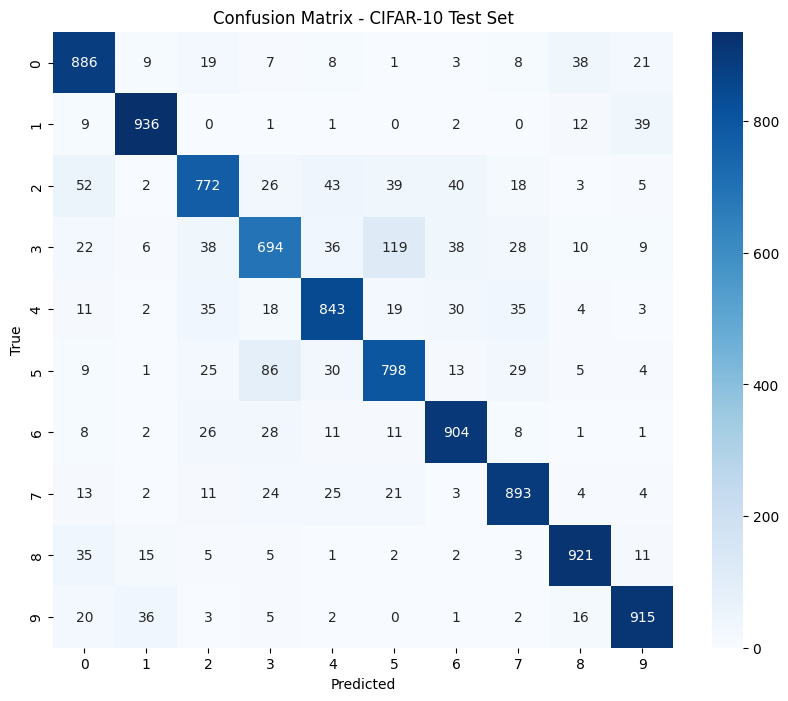

In [ ]:
#Now, we apply the model on test data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize prediction and label containers
all_preds = []
all_labels = []

# Ensure model is in evaluation mode
best_model.eval()

# Run inference on the test set
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

# Print results
print(f"Test Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CIFAR-10 Test Set")
plt.show()


## Load CIFAR-100, fine-tune the model on it and report the model performance metrics

In [30]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Build a Transform (bases on CIFAR-10 normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])
# 3. Load CIFAR-100 Test Set
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [31]:
#Load CIFAR-10 Pretrained Model
model = CustomCNN32(num_classes=10, deep=False)  # same config used during training

# Replace classifier with dummy to avoid size mismatch
model.classifier = nn.Identity()

# Load weights (except classifier)
state_dict = torch.load("best_model_6Layers_augmented.pth", map_location=device)
model.load_state_dict(state_dict, strict=False)

# Dynamically fix classifier shape
# Use CIFAR-100 data just to probe output shape
model.to(device)
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        out = model.conv1(images)
        out = model.block1(out)
        out = model.pool1(out)
        out = model.block2(out)
        out = model.block3(out)
        out = model.block4(out)
        flat_dim = out.view(out.size(0), -1).size(1)
        break

# Replace classifier for CIFAR-100
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(flat_dim, 100),  # CIFAR-100 classes
    nn.Softmax(dim=1)
)
model.to(device)


CustomCNN32(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

Test Accuracy: 0.0090
Precision: 0.0056, Recall: 0.0090, F1 Score: 0.0033


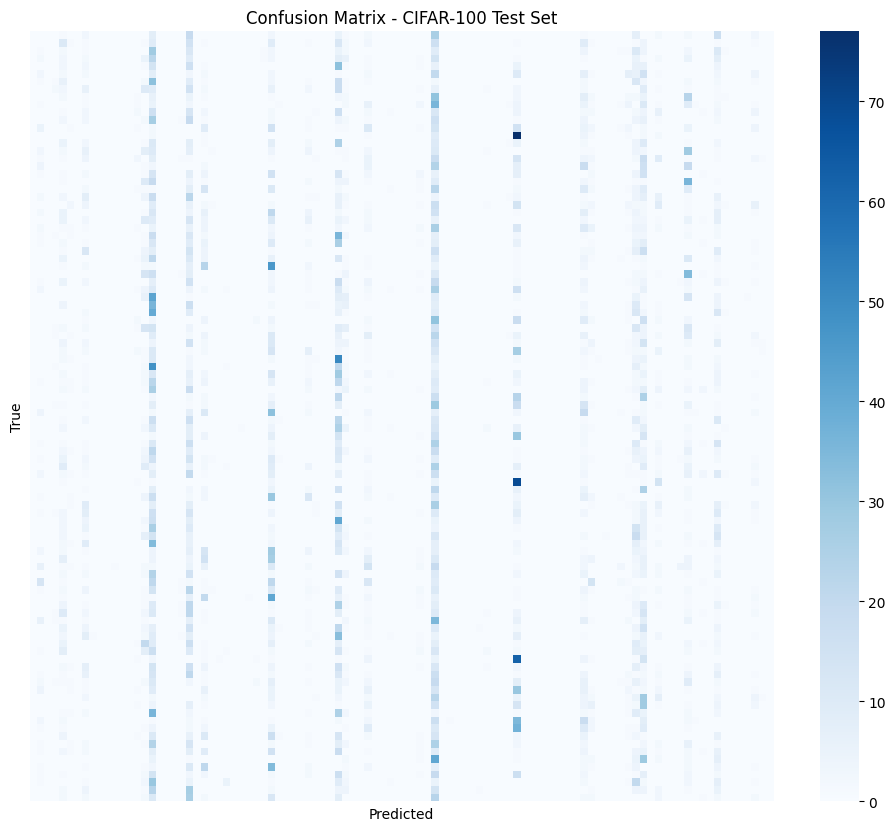

In [29]:

# Inference on CIFAR-100
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculating Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CIFAR-100 Test Set")
plt.show()


**Interpretation**:
Ok, this was expected cause we are using a model that was trained to classify images into 10 classes to predict 100 classes It was trained to recognize trucks, dogs, planes…
Now asked to recognize fine-grained new classes like maple trees, orchids, castles, wardrobes, etc.

If we guessed randomly the chance of guessing correct was 1/100 = 0.01 and our accuracy is the same.

Next steps:

1. First, we will check the first level categories (20 classes) of CIFAR-100 instead of all 100 detailed classes.

2. We retrain the model for CIFA-100 for a few epochs to update the weights on the classifier level.

### Select the first level labels of images in cIFA-100

In [35]:
import os
import pickle
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np

# 1. CIFAR-10 normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# 2. Load CIFAR-100 test set (fine labels)
cifar100_fine = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)

# 3. Load the coarse labels manually from the CIFAR-100 test data file
with open('./data/cifar-100-python/test', 'rb') as f:
    cifar100_raw = pickle.load(f, encoding='latin1')

coarse_labels = np.array(cifar100_raw['coarse_labels'])  # 20 categories

# 4. Dataset wrapper that uses coarse labels instead of fine
class CoarseLabelDataset(Dataset):
    def __init__(self, original_dataset, coarse_labels):
        self.original = original_dataset
        self.coarse_labels = coarse_labels

    def __getitem__(self, idx):
        image, _ = self.original[idx]  # ignore fine label
        label = self.coarse_labels[idx]
        return image, label

    def __len__(self):
        return len(self.original)

# 5. Create dataset and dataloader
coarse_dataset = CoarseLabelDataset(cifar100_fine, coarse_labels)
test_loader = DataLoader(coarse_dataset, batch_size=64, shuffle=False)


Test Accuracy: 0.0592
Precision: 0.0396, Recall: 0.0592, F1 Score: 0.0327


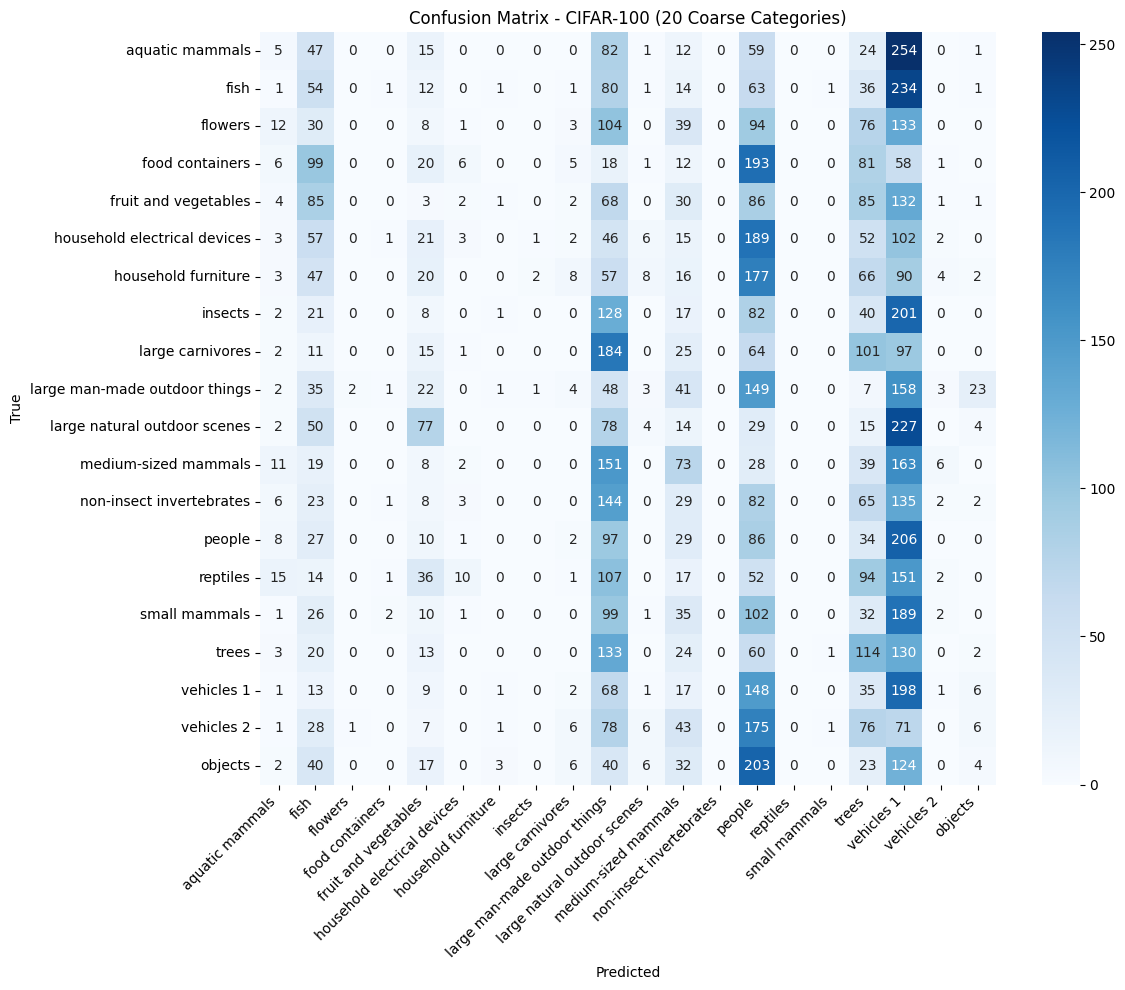

In [36]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 6. Dynamically compute classifier input size
model.to(device)
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        out = model.conv1(images)
        out = model.block1(out)
        out = model.pool1(out)
        out = model.block2(out)
        out = model.block3(out)
        out = model.block4(out)
        flat_dim = out.view(out.size(0), -1).size(1)
        break

# 7. Replace classifier for 20 coarse categories
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(flat_dim, 20),
    nn.Softmax(dim=1)
)
model.to(device)

# 8. Inference
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 9. Evaluation metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")

# 10. Confusion matrix
coarse_label_names = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
    'household electrical devices', 'household furniture', 'insects',
    'large carnivores', 'large man-made outdoor things', 'large natural outdoor scenes',
    'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles',
    'small mammals', 'trees', 'vehicles 1', 'vehicles 2', 'objects'
]

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=coarse_label_names,
            yticklabels=coarse_label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CIFAR-100 (20 Coarse Categories)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Interpretation**
Our model was pretrained on CIFAR-10 (classes: ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']).

Now, it's being tested on CIFAR-100's 20 coarse categories which are very different and diverse.
So, it gets 5.9 accuracy, which is a little better than random (1/20 = 5%), but not good — because it's never seen most of these categories.

What I found interesting is that it performing better at classsifying
- People
- Trees
- Vehicles 1 & 2
- Large natural outdoor things

And I would say people pictures has similar feaurures with animals. Also, we had Airplane, Automobile, Ship and Truck which are close to Vehicles 1 & 2 & Large natural outdoor things.
So, our model is transferring knowledge from CIFAR-10 to predicting on coarse categories in CIFAR-100.

### Now, we will continue to retrain the model for a small number of epochs for the CIFAR-100 (20 first level labels).

In [55]:
# -------------------------
# 1. Data Augmentation & Normalization
# -------------------------
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# -------------------------
# 2. Load CIFAR-100 Train Set (Fine labels)
# -------------------------
cifar100_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)

# 3. Load coarse labels manually
with open('./data/cifar-100-python/train', 'rb') as f:
    train_raw = pickle.load(f, encoding='latin1')

coarse_train_labels = np.array(train_raw['coarse_labels'])  # 0–19 coarse classes

# 4. Wrap training dataset to use coarse labels
class CoarseTrainDataset(Dataset):
    def __init__(self, original_dataset, coarse_labels):
        self.original = original_dataset
        self.coarse_labels = coarse_labels

    def __getitem__(self, idx):
        image, _ = self.original[idx]
        return image, self.coarse_labels[idx]

    def __len__(self):
        return len(self.original)

train_dataset = CoarseTrainDataset(cifar100_train, coarse_train_labels)

# -------------------------
# 5. Split train dataset into train/val
# -------------------------
train_len = int(0.9 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_subset, val_subset = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)


In [57]:
# -------------------------
# Read the original CIFAR-10 pretrained model
# -------------------------
cifar10_checkpoint_path =  'best_model_6Layers_augmented.pth'

# Instantiate the original architecture
model_ft = CustomCNN32(num_classes=10, deep=False)  # Set deep=True if that’s how it was trained

# Remove classifier to avoid shape mismatch
model_ft.classifier = nn.Identity()

# Load pretrained weights
model_ft.load_state_dict(torch.load(cifar10_checkpoint_path, map_location=device), strict=False)

# Dynamically determine classifier input size
model_ft.eval()
model_ft.to(device)
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        x = model_ft.conv1(images)
        x = model_ft.block1(x)
        x = model_ft.pool1(x)
        x = model_ft.block2(x)
        x = model_ft.block3(x)
        x = model_ft.block4(x)
        flat_dim = x.view(x.size(0), -1).size(1)
        break

# Replace classifier with new head for CIFAR-100 coarse (20 classes)
model_ft.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(flat_dim, 20)
)
model_ft.to(device)


CustomCNN32(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [58]:
# -------------------------
# 6. Training Setup
# -------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.0005)
epochs = 20
early_stop_patience = 10
best_val_acc = 0.0
best_epoch = 0
patience_counter = 0
model_save_path = 'best_model_finetuned_cifar100.pth'

# Trackers
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# -------------------------
# Training with Validation + Early Stopping
# -------------------------
for epoch in range(epochs):
    start_time = time.time()

    model_ft.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model_ft(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model_ft.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_ft(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            _, val_preds = torch.max(val_outputs, 1)
            val_correct += (val_preds == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    elapsed_time = time.time() - start_time

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        patience_counter = 0
        torch.save(model_ft.state_dict(), model_save_path)
    else:
        patience_counter += 1

    if (epoch + 1) % 5 == 0 or epoch == 0 or epoch + 1 == epochs:
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.3f}, Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.3f}, Acc: {val_acc:.3f} | "
              f"Time: {elapsed_time:.1f}s")

    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1}. Best Val Acc: {best_val_acc:.4f} at epoch {best_epoch+1}")
        break

print(f"Best Val Acc: {best_val_acc:.4f} (epoch {best_epoch+1})")


Epoch 1/20 | Train Loss: 2.377, Acc: 0.297 | Val Loss: 1.777, Acc: 0.436 | Time: 55.0s
Epoch 5/20 | Train Loss: 1.552, Acc: 0.503 | Val Loss: 1.389, Acc: 0.554 | Time: 56.3s
Epoch 10/20 | Train Loss: 1.322, Acc: 0.575 | Val Loss: 1.234, Acc: 0.608 | Time: 53.2s
Epoch 15/20 | Train Loss: 1.183, Acc: 0.618 | Val Loss: 1.153, Acc: 0.630 | Time: 52.6s
Epoch 20/20 | Train Loss: 1.087, Acc: 0.647 | Val Loss: 1.075, Acc: 0.655 | Time: 52.6s
Best Val Acc: 0.6550 (epoch 20)


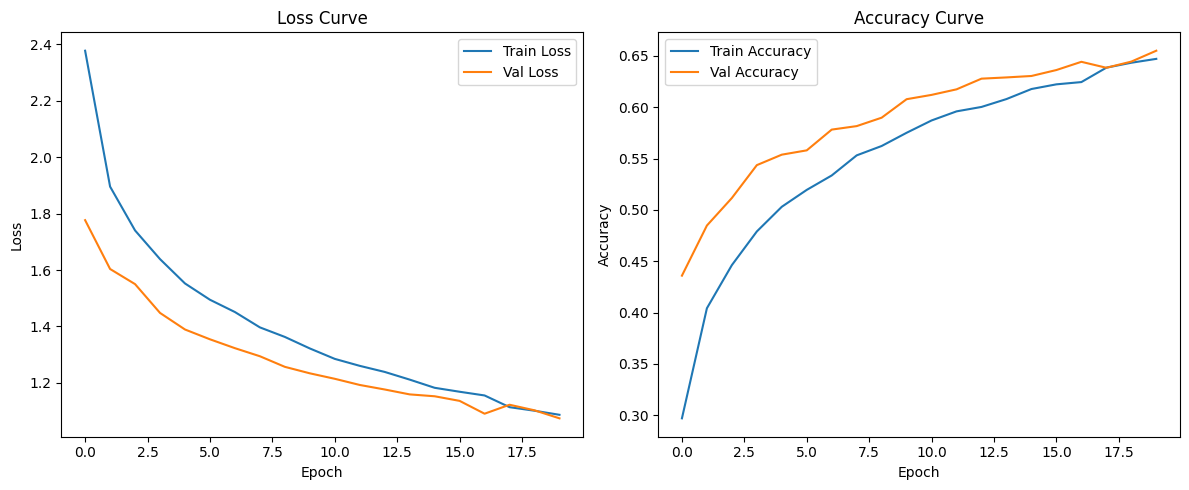

In [59]:
#save the best model
torch.save(model_ft.state_dict(), 'best_model_finetuned_cifar100.pth')

#Plot the training process and results
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

Ok, now we will test the final model on CIFAR-100 test set.

In [60]:
import pickle
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

# CIFAR-10 normalization
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load CIFAR-100 test set with fine labels
cifar100_test = datasets.CIFAR100(root='./data', train=False, transform=transform_test, download=True)

# Load coarse labels manually
with open('./data/cifar-100-python/test', 'rb') as f:
    test_data = pickle.load(f, encoding='latin1')
coarse_test_labels = np.array(test_data['coarse_labels'])

# Dataset wrapper for coarse labels
class CIFAR100CoarseTest(Dataset):
    def __init__(self, base_dataset, coarse_labels):
        self.base = base_dataset
        self.coarse_labels = coarse_labels

    def __getitem__(self, idx):
        image, _ = self.base[idx]
        label = self.coarse_labels[idx]
        return image, label

    def __len__(self):
        return len(self.base)

coarse_test_dataset = CIFAR100CoarseTest(cifar100_test, coarse_test_labels)
test_loader = DataLoader(coarse_test_dataset, batch_size=64, shuffle=False)


In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure model is in eval mode
model_ft.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_ft(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Evaluation metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")


Test Accuracy: 0.6710
Precision: 0.6712, Recall: 0.6710, F1 Score: 0.6691


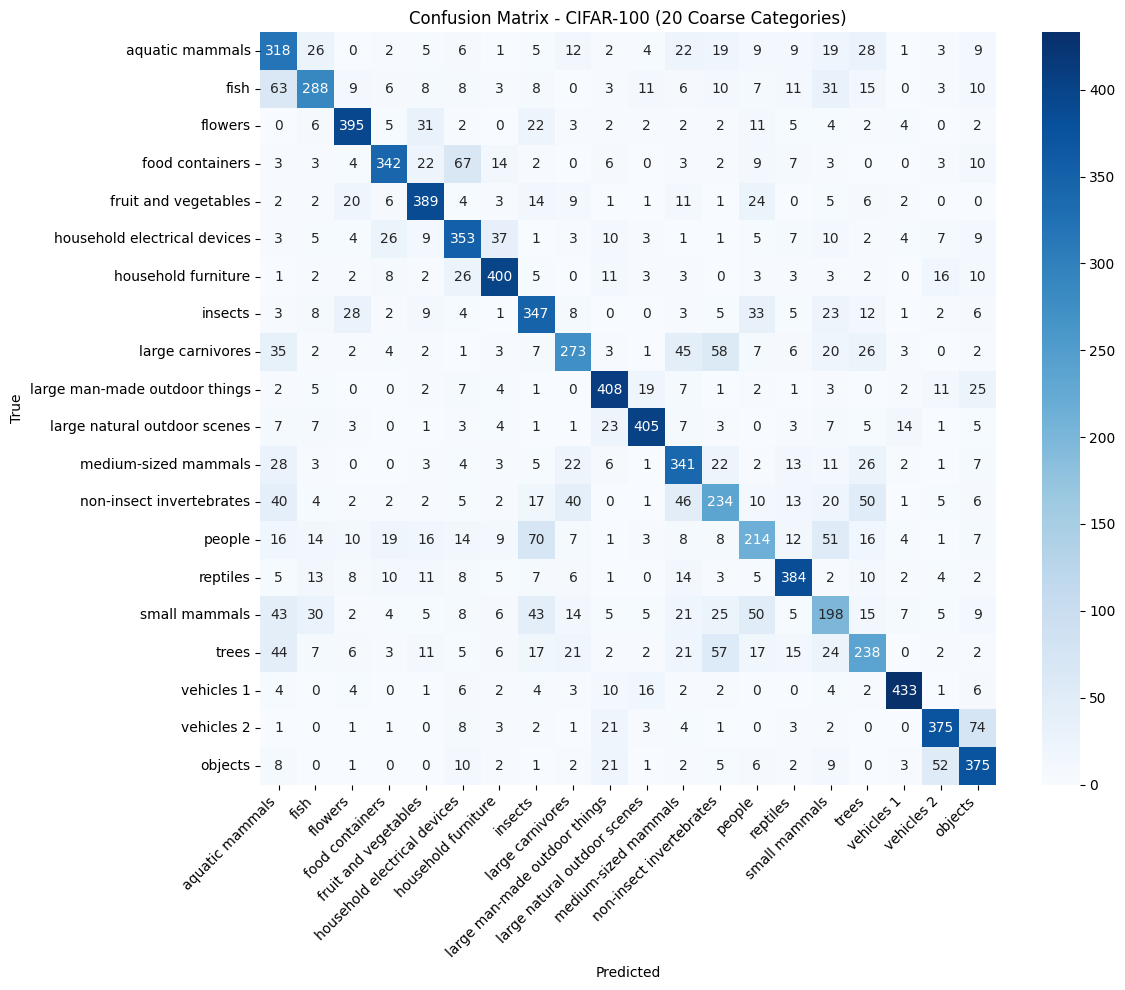

In [62]:
coarse_label_names = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
    'household electrical devices', 'household furniture', 'insects',
    'large carnivores', 'large man-made outdoor things', 'large natural outdoor scenes',
    'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles',
    'small mammals', 'trees', 'vehicles 1', 'vehicles 2', 'objects'
]

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=coarse_label_names,
            yticklabels=coarse_label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CIFAR-100 (20 Coarse Categories)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Interpretation and insights on misclassified images**

We finally got a **67% test accuracy** after fine-tuning our model and that is a great improvement from where we started, which was just random guessing.

Looking at the confusion matrix, we can see that the model performs well on many classes, like "flowers", "household furniture", and "vehicles".

However, several classes are being misclassified often such as "non-insect invertebrates", and "small mammals".

This misclassification happens when classes are visually similar. For example, we see on the matrix that small mammels were mostly confused with: "fish", "insects", "people" and other types of mammels. This is good sign cause all of these classes are animals (People are also kinf of animals:D) and this tells us the model is understands the context well but lacks percision in details.

To improve this, we could apply **targeted data augmentation** for confusing classes, use **class-specific sampling** to ensure better balance during training, or **fine-tune deeper layers of the model instead of just the classifier**.

# Visualization

In [68]:
# -------------------------
# Load the best fine-tuned model on CIFAR-100 (20 coarse)
# -------------------------
best_model_path = 'best_model_finetuned_cifar100.pth'

# Recreate the model architecture exactly as used before
best_model = CustomCNN32(num_classes=10, deep=False)  # Use deep=True if you trained with that setting

# Dummy classifier to bypass mismatch during weight loading
best_model.classifier = nn.Identity()

# Load weights from the best saved model
best_model.load_state_dict(torch.load(best_model_path, map_location=device), strict=False)

# Dynamically determine classifier input size
best_model.eval()
best_model.to(device)

with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        x = best_model.conv1(images)
        x = best_model.block1(x)
        x = best_model.pool1(x)
        x = best_model.block2(x)
        x = best_model.block3(x)
        x = best_model.block4(x)
        flat_dim = x.view(x.size(0), -1).size(1)
        break

# Replace classifier with the correct one for 20 coarse classes
best_model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(flat_dim, 20)
)

best_model.to(device)
best_model.eval()

CustomCNN32(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

## Visualize Feauture Map

 (also called an activation map) is the output of a convolutional layer after applying filters to an input image

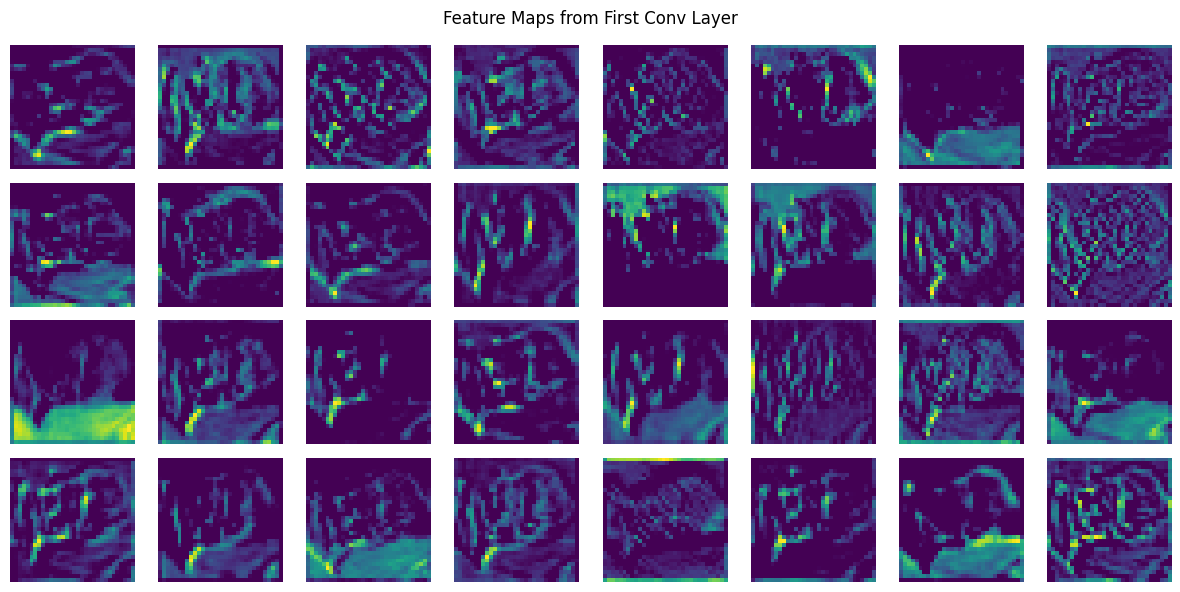

In [ ]:
def visualize_feature_maps(model, image_tensor):
    image_tensor = image_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        x = best_model.conv1(image_tensor)
        feature_maps = x.squeeze(0).cpu()

    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(feature_maps[i], cmap='viridis')
        ax.axis('off')
    plt.suptitle("Feature Maps from First Conv Layer")
    plt.tight_layout()
    plt.show()

# Example
image, _ = test_set[0]
visualize_feature_maps(best_model, image)


**Note**:
- Early convolutional layers (like Conv1) learn low-level features.
These include edges, corners, blobs, gradients, and basic texture patterns.
You can see areas that are activated (brighter) when the model "detects" patterns.
- Brighter spots in each small image (channel) show where the filter "fired" or activated.

## Grad-CAM Visualization
This gives visual explanations of which image regions influenced the decision.

In [ ]:
pip install torchcam


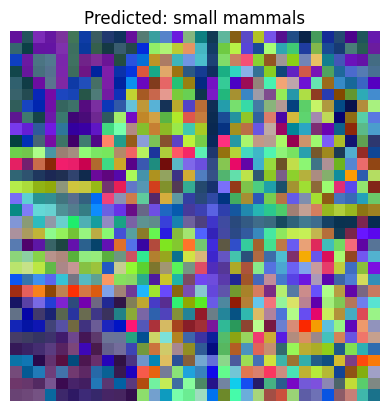

In [69]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# Use the correct model
best_model.eval()

# Set up GradCAM on a valid target layer (deep convolution layer)
cam_extractor = GradCAM(model=best_model, target_layer="block3.0.conv2")  # Adjust if needed

# Load a test image from CIFAR-100 test set
image, label = coarse_test_dataset[1]  # You can change the index

# Prepare input tensor
input_tensor = image.unsqueeze(0).to(device)

# Forward pass
output = best_model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Extract CAM for the predicted class
activation_map = cam_extractor(pred_class, output)

# Overlay CAM on original image
result = overlay_mask(
    to_pil_image(image),                   # Original image
    to_pil_image(activation_map[0]),      # CAM heatmap
    alpha=0.5
)

# Show image with heatmap overlay
coarse_label_names = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
    'household electrical devices', 'household furniture', 'insects',
    'large carnivores', 'large man-made outdoor things', 'large natural outdoor scenes',
    'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles',
    'small mammals', 'trees', 'vehicles 1', 'vehicles 2', 'objects'
]

plt.imshow(result)
plt.title(f"Predicted: {coarse_label_names[pred_class]}")
plt.axis('off')
plt.show()


**Note:**

The Grad-CAM heatmap look messy and visually interpretable.
This happens because CIFAR-100 images are very small (32x32 pixels) and as the Grad-CAM heatmap will result in pixation,
over-saturation of colors and loss of fine details and visible patterns.

# Future Improvement Suggestions

Explore techniques on learning rate scheduling and test different starting points.

Using deeper CNN architectures (e.g., 7+ convolutional layers) or experiment with pretrained models like ResNet or EfficientNet for transfer learning.

Implement more advanced data augmentation techniques (e.g., CutMix, MixUp, random erasing) to further improve generalization.

Experiment with different optimizers (e.g., SGD with momentum, RMSprop) and learning rate schedulers (like Cosine Annealing) for potentially faster or better convergence.

Investigate class-wise performance and use confusion matrices to better understand which categories are harder to classify and why.

For Grad, Cam Vizualization, we can resize the image and the activation map to make the heatmap clearer and actually interpretable.